In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
% matplotlib inline
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = 'tight'
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter('ignore', (FutureWarning, ConvergenceWarning))

# Feature importances and Model interpretation

In [4]:
# generate data from original 2d linear model
from sklearn.preprocessing import scale

# 35 13 50? 
rng = np.random.RandomState(13)
n_samples = 100000
n_informative = 2
n_correlated_per_inf = 2
n_noise = 4
noise_std = .001
noise_correlated_std = .4
noise_y = .5


X_original = rng.uniform(-1, 1, size=(n_samples, n_informative))
coef = rng.normal(size=n_informative)
y = np.dot(X_original, coef) + rng.normal(scale=noise_y, size=n_samples)

correlated_transform = np.zeros((n_correlated_per_inf * n_informative, n_informative))
for i in range(n_informative):
    correlated_transform[i * n_correlated_per_inf: (i + 1) * n_correlated_per_inf, i] = rng.normal(size=n_correlated_per_inf)
X_original += rng.normal(scale=noise_correlated_std, size=X_original.shape)
X_correlated = np.dot(X_original, correlated_transform.T)

X = np.hstack([X_correlated, np.zeros((n_samples, n_noise))])
X += rng.normal(scale=noise_std, size=X.shape)
X = scale(X)

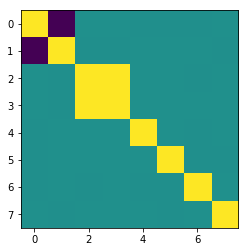

In [5]:
plt.imshow(np.cov(X, rowvar=False))

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [8]:
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
lasso = LassoCV().fit(X_train, y_train)
lasso.score(X_test, y_test)

0.6000790009484334

In [9]:
ridge = RidgeCV().fit(X_train, y_train)
ridge.score(X_test, y_test)

0.6000920429136388

In [10]:
lr = LinearRegression().fit(X_train, y_train)
lr.score(X_test, y_test)

0.6000926951310834

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=.99).fit(X_train)
X_train_pca = pca.transform(X_train)
lr_pca = LinearRegression().fit(X_train_pca, y_train)
inverse_lr_pca_coef = pca.inverse_transform(lr_pca.coef_)
lr_pca.score(pca.transform(X_test), y_test)

0.5999582851573628

In [12]:
pca.n_components_

6

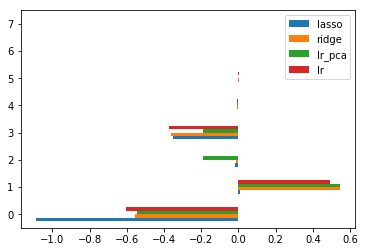

In [13]:
pd.DataFrame({'lasso': lasso.coef_, 'ridge': ridge.coef_, 'lr_pca': inverse_lr_pca_coef, 'lr': lr.coef_}).plot(kind='barh')

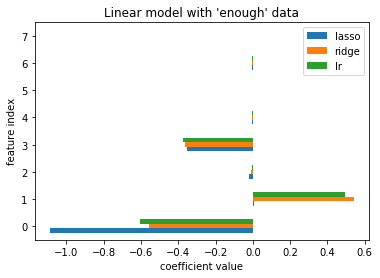

In [14]:
pd.DataFrame({'lasso': lasso.coef_, 'ridge': ridge.coef_, 'lr': lr.coef_}).plot(kind='barh')
plt.ylabel("feature index")
plt.xlabel("coefficient value")
plt.title("Linear model with 'enough' data")
plt.savefig("images/linear_enough_data.png")

In [15]:
# X_test is actually big, not small, but that would be confusing naming, right?
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X, y, train_size=0.001, random_state=0)
X_train_small.shape

(100, 8)

In [16]:
lasso = LassoCV().fit(X_train_small, y_train_small)
lasso.score(X_test_small, y_test_small)

0.5763894728535515

In [17]:
ridge = RidgeCV().fit(X_train_small, y_train_small)
ridge.score(X_test_small, y_test_small)

0.5739080268984393

In [18]:
lr = LinearRegression().fit(X_train_small, y_train_small)
lr.score(X_test_small, y_test_small)

0.5628596345876247

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=.99).fit(X_train_small)
X_train_pca = pca.transform(X_train_small)
lr_pca = LinearRegression().fit(X_train_pca, y_train_small)
inverse_lr_pca_coef = pca.inverse_transform(lr_pca.coef_)
lr_pca.score(pca.transform(X_test_small), y_test_small)

0.5722794583672836

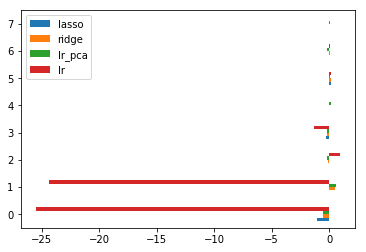

In [20]:
pd.DataFrame({'lasso': lasso.coef_, 'ridge': ridge.coef_, 'lr_pca': inverse_lr_pca_coef, 'lr': lr.coef_}).plot(kind='barh')

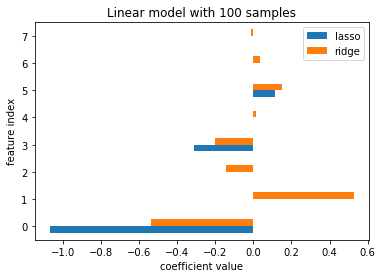

In [21]:
pd.DataFrame({'lasso': lasso.coef_, 'ridge': ridge.coef_}).plot(kind='barh')
plt.ylabel("feature index")
plt.xlabel("coefficient value")
plt.title("Linear model with 100 samples")
plt.savefig("images/linear_less_data.png")

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {'max_leaf_nodes': range(2, 40, 5)}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10)
grid.fit(X_train, y_train)
grid.score(X_test, y_test)

In [28]:
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.143135,0.015004,0.000681,0.000045,2,{'max_leaf_nodes': 2},0.427239,0.416085,0.424098,0.433173,0.432156,0.422446,0.426663,0.435429,0.438946,0.416820,0.427306,0.007277,18
1,0.167587,0.013031,0.000703,0.000045,3,{'max_leaf_nodes': 3},0.476060,0.463983,0.471775,0.480641,0.478602,0.470345,0.482485,0.481514,0.488788,0.470508,0.476470,0.006975,17
2,0.200635,0.006756,0.000747,0.000099,4,{'max_leaf_nodes': 4},0.520224,0.506497,0.517705,0.525629,0.521397,0.514983,0.525306,0.528097,0.530995,0.515789,0.520662,0.006888,16
3,0.212318,0.015436,0.000750,0.000064,5,{'max_leaf_nodes': 5},0.535542,0.522571,0.530112,0.538828,0.532202,0.529558,0.540946,0.538715,0.544074,0.529259,0.534181,0.006233,15
4,0.232033,0.023365,0.000766,0.000059,6,{'max_leaf_nodes': 6},0.548416,0.535974,0.541404,0.553063,0.543889,0.543404,0.551852,0.552494,0.552837,0.540676,0.546401,0.005818,14
5,0.241055,0.014526,0.000812,0.000109,7,{'max_leaf_nodes': 7},0.563577,0.547196,0.552169,0.562465,0.557129,0.556122,0.562720,0.564814,0.564532,0.553686,0.558441,0.005780,13
6,0.261824,0.020113,0.000816,0.000060,8,{'max_leaf_nodes': 8},0.573435,0.561322,0.562850,0.578803,0.569094,0.565832,0.574245,0.574668,0.577038,0.562807,0.570009,0.006124,12
7,0.264866,0.020440,0.000840,0.000143,9,{'max_leaf_nodes': 9},0.576855,0.565628,0.567080,0.582086,0.572720,0.569823,0.578141,0.578839,0.580066,0.565893,0.573713,0.005940,11
8,0.265258,0.020472,0.000814,0.000076,10,{'max_leaf_nodes': 10},0.580660,0.569827,0.570548,0.585047,0.575657,0.574786,0.581582,0.582274,0.584201,0.568994,0.577358,0.005843,10
9,0.274208,0.019793,0.000813,0.000076,11,{'max_leaf_nodes': 11},0.583955,0.573281,0.573480,0.588050,0.578927,0.576416,0.584593,0.585620,0.586661,0.571687,0.580267,0.005895,9


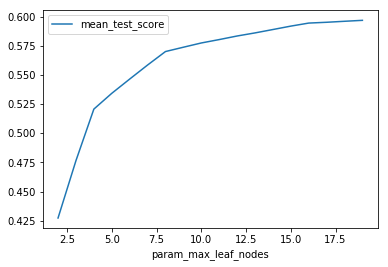

In [30]:
res = pd.DataFrame(grid.cv_results_)
res.plot(x='param_max_leaf_nodes', y='mean_test_score')

# Feature Selection

In [7]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [8]:
boston = load_boston()
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [9]:
from sklearn.preprocessing import scale
X_train_scaled = scale(X_train)
cov = np.cov(X_train_scaled, rowvar=False)

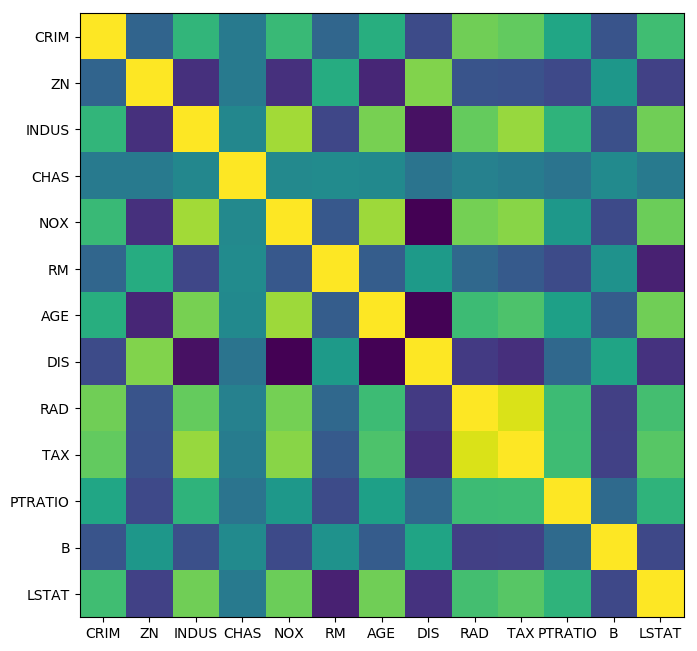

In [10]:
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(cov)
plt.xticks(range(X.shape[1]), boston.feature_names)
plt.yticks(range(X.shape[1]), boston.feature_names);

In [11]:
from scipy.cluster import hierarchy
order = np.array(hierarchy.dendrogram(hierarchy.ward(cov), no_plot=True)['ivl'], dtype="int")

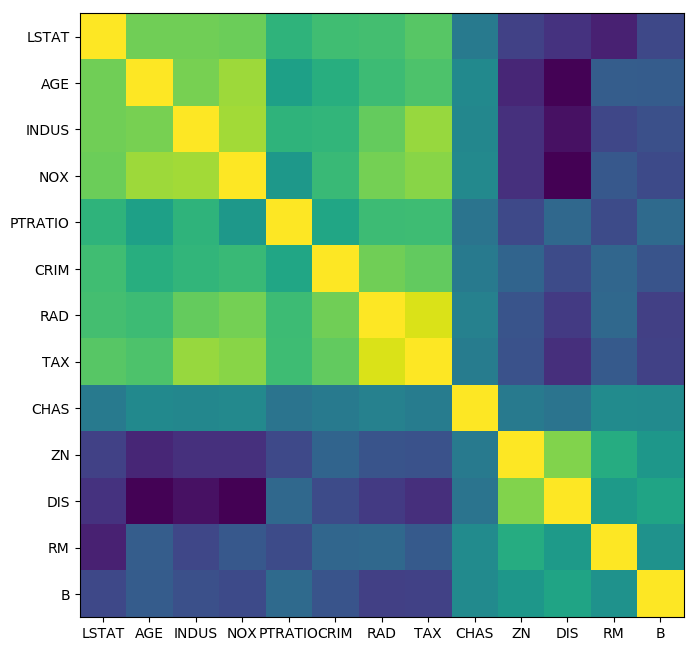

In [12]:
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(cov[order, :][:, order])
plt.xticks(range(X.shape[1]), boston.feature_names[order])
plt.yticks(range(X.shape[1]), boston.feature_names[order]);

# Supervised feature selection

In [13]:
from sklearn.feature_selection import f_regression
f_values, p_values = f_regression(X, y)

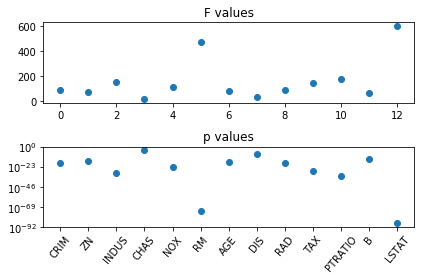

In [14]:
fig, ax = plt.subplots(2, 1)
ax[0].set_title("F values")
ax[0].plot(f_values, 'o')
ax[1].set_title("p values")
ax[1].plot(p_values, 'o')
ax[1].set_yscale("log")

ax[1].set_xticks(range(X.shape[1]))
ax[1].set_xticklabels(boston.feature_names, rotation=50);
fig.tight_layout()

In [15]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFpr
from sklearn.linear_model import RidgeCV

select = SelectKBest(k=2, score_func=f_regression)
select.fit(X_train, y_train)
print(X_train.shape)
print(select.transform(X_train).shape)

(379, 13)
(379, 2)


In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
all_features = make_pipeline(StandardScaler(), RidgeCV())
select_2 = make_pipeline(StandardScaler(), SelectKBest(k=2, score_func=f_regression), RidgeCV())

In [21]:
from sklearn.model_selection import cross_val_score
np.mean(cross_val_score(all_features, X_train, y_train, cv=10))

0.71795885107509

In [22]:
np.mean(cross_val_score(select_2, X_train, y_train, cv=10))

0.6243625749168433

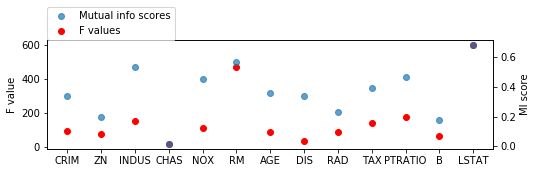

In [23]:
from sklearn.feature_selection import mutual_info_regression
scores = mutual_info_regression(X_train, y_train, discrete_features=[3])

fig = plt.figure(figsize=(8, 2))
line_f, = plt.plot(f_values, 'o', c='r')
plt.ylabel("F value")
ax2 = plt.twinx()
line_s, = ax2.plot(scores, 'o', alpha=.7)
ax2.set_ylabel("MI score")
plt.xticks(range(X.shape[1]), boston.feature_names)
plt.legend([line_s, line_f], ["Mutual info scores", "F values"], loc=(0, 1))

In [35]:
from sklearn.linear_model import Lasso
X_train_scaled = scale(X_train)
lasso = LassoCV().fit(X_train_scaled, y_train)
print(lasso.coef_)

[-0.          0.         -0.          0.         -0.          2.52933025
 -0.         -0.         -0.         -0.22763148 -1.70088382  0.13186059
 -3.60565498]


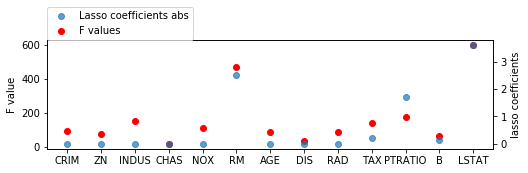

In [36]:
fig = plt.figure(figsize=(8, 2))
line_f, = plt.plot(f_values, 'o', c='r')
plt.ylabel("F value")
ax2 = plt.twinx()
ax2.set_ylabel("lasso coefficients")
line_s, = ax2.plot(np.abs(lasso.coef_), 'o', alpha=.7)
plt.xticks(range(X.shape[1]), boston.feature_names)
plt.legend([line_s, line_f], ["Lasso coefficients abs", "F values"], loc=(0, 1))

In [37]:
from sklearn.linear_model import Lasso
X_train_scaled = scale(X_train)
lasso = Lasso().fit(X_train_scaled, y_train)
print(lasso.coef_)

[-0.          0.         -0.          0.         -0.          2.52933025
 -0.         -0.         -0.         -0.22763148 -1.70088382  0.13186059
 -3.60565498]


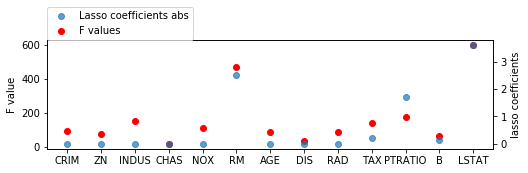

In [38]:
fig = plt.figure(figsize=(8, 2))
line_f, = plt.plot(f_values, 'o', c='r')
plt.ylabel("F value")
ax2 = plt.twinx()
ax2.set_ylabel("lasso coefficients")
line_s, = ax2.plot(np.abs(lasso.coef_), 'o', alpha=.7)
plt.xticks(range(X.shape[1]), boston.feature_names)
plt.legend([line_s, line_f], ["Lasso coefficients abs", "F values"], loc=(0, 1))

In [40]:
X_train.shape

(379, 13)

In [44]:
from sklearn.feature_selection import SelectFromModel
select_lassocv = SelectFromModel(LassoCV())
select_lassocv.fit(X_train, y_train)
print(select_lassocv.transform(X_train).shape)

(379, 11)


In [45]:
pipe_lassocv = make_pipeline(StandardScaler(), select_lassocv, RidgeCV())
np.mean(cross_val_score(pipe_lassocv, X_train, y_train, cv=10))

0.7171231551882247

In [79]:
np.mean(cross_val_score(all_features, X_train, y_train, cv=10))

0.71798347520832284

In [68]:
# could grid-search alpha in lasso
select_lasso = SelectFromModel(Lasso())
pipe_lasso = make_pipeline(StandardScaler(), select_lasso, RidgeCV())
np.mean(cross_val_score(pipe_lasso, X_train, y_train, cv=10))

0.67051240477576868

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# create ranking among all features by selecting only one
rfe = RFE(LinearRegression(), n_features_to_select=1)
rfe.fit(X_train_scaled, y_train)
rfe.ranking_

array([ 9,  8, 13, 11,  5,  2, 12,  4,  7,  6,  3, 10,  1])

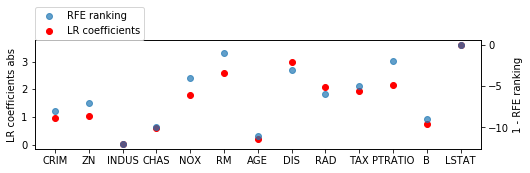

In [70]:
lr = LinearRegression().fit(X_train_scaled, y_train)
fig = plt.figure(figsize=(8, 2))
line_f, = plt.plot(np.abs(lr.coef_), 'o', c='r')
plt.ylabel("LR coefficients abs")
ax2 = plt.twinx()
ax2.set_ylabel("1 - RFE ranking")
line_s, = ax2.plot(1 - rfe.ranking_, 'o', alpha=.7)
plt.xticks(range(X.shape[1]), boston.feature_names)
plt.legend([line_s, line_f], ["RFE ranking", "LR coefficients"], loc=(0, 1))

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV

rfe = RFECV(LinearRegression(), cv=10)
rfe.fit(X_train_scaled, y_train)
print(rfe.support_)
print(boston.feature_names[rfe.support_])

[ True  True False  True  True  True False  True  True  True  True  True
  True]
['CRIM' 'ZN' 'CHAS' 'NOX' 'RM' 'DIS' 'RAD' 'TAX' 'PTRATIO' 'B' 'LSTAT']


In [72]:
pipe_rfe_ridgecv = make_pipeline(StandardScaler(), RFECV(LinearRegression(), cv=10), RidgeCV())
np.mean(cross_val_score(pipe_rfe_ridgecv, X_train, y_train, cv=10))

0.71019583375843598

In [73]:
from sklearn.preprocessing import PolynomialFeatures
pipe_rfe_ridgecv = make_pipeline(StandardScaler(), PolynomialFeatures(), RFECV(LinearRegression(), cv=10), RidgeCV())
np.mean(cross_val_score(pipe_rfe_ridgecv, X_train, y_train, cv=10))

0.82031507795494429

In [74]:
pipe_rfe_ridgecv.fit(X_train, y_train)
print(pipe_rfe_ridgecv.named_steps['rfecv'].support_)

[False  True  True  True False  True  True  True False  True  True False
  True  True False  True  True  True  True False False False  True  True
  True False False  True  True False  True False False False False  True
  True  True False  True False False False  True  True  True  True  True
  True  True False  True False False  True False False False  True False
 False False  True  True  True  True  True False False False  True  True
 False  True  True False False False False  True  True False  True  True
  True  True False False  True  True  True  True  True  True  True  True
  True False  True False  True False False False  True]


In [75]:
from mlxtend.feature_selection import SequentialFeatureSelector
sfs = SequentialFeatureSelector(LinearRegression(), forward=False, k_features=7)
sfs.fit(X_train_scaled, y_train)

ModuleNotFoundError: No module named 'mlxtend'

In [ ]:
print(sfs.k_feature_idx_)
print(boston.feature_names[np.array(sfs.k_feature_idx_)])

In [ ]:
sfs.k_score_